In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/ai-club-induction-2023-24/training_data.csv")
df.head()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default
0,1033,28,1.0,Aadhar,777600.0,961200.0,0,0,0,0
1,6340,39,2.0,Aadhar,463848.0,1046532.0,5,3,0,0
2,3887,27,2.0,Aadhar,654984.0,865380.0,2,0,0,1
3,2654,29,2.0,VoterID,691716.0,867792.0,0,0,0,1
4,6915,37,1.0,Aadhar,796584.0,961200.0,0,0,0,0


# Basic Data Cleaning

In [3]:
df.isnull().sum()

loan_id               0
age                   0
education           189
proof_submitted       0
loan_amount           0
asset_cost            0
no_of_loans           0
no_of_curr_loans      0
last_delinq_none      0
loan_default          0
dtype: int64

In [4]:
# Get unique values from a specific column
unique_values = df['education'].unique()
unique_values

array([ 1.,  2., nan])

In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split
one_hot_encoder = OneHotEncoder(sparse=False)
proof_submitted_encoded = df[['proof_submitted']]
proof_submitted_one_hot = one_hot_encoder.fit_transform(proof_submitted_encoded)
proof_submitted_one_hot_df = pd.DataFrame(proof_submitted_one_hot, columns=[f'proof_submitted_{i}' for i in range(proof_submitted_one_hot.shape[1])])

df = pd.concat([df, proof_submitted_one_hot_df], axis=1)
df.drop(['proof_submitted',], axis=1, inplace=True)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
import pandas as pd

columns_to_remove = ['loan_id']
df = df.drop(columns=columns_to_remove)
df.head()


,age,education,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,proof_submitted_0,proof_submitted_1,proof_submitted_2,proof_submitted_3,proof_submitted_4,proof_submitted_5,proof_submitted_6
0,28,1.0,777600.0,961200.0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39,2.0,463848.0,1046532.0,5,3,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27,2.0,654984.0,865380.0,2,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29,2.0,691716.0,867792.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37,1.0,796584.0,961200.0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
cat1=['age','loan_amount','asset_cost','no_of_loans','no_of_curr_loans']

In [8]:
# custom function for easy outlier analysis

def UVA_outlier(df, var_group, include_outlier = True):
  '''
  Univariate_Analysis_outlier:
  takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

  data : dataframe from which to plot from\n
  var_group : {list} type Group of Continuous variables\n
  include_outlier : {bool} whether to include outliers or not, default = True\n
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 100)
  # df2 = df[var_group][:]
  #looping for each variable
  for j,i in enumerate(var_group):

    # calculating descriptives of variable
    quant25 = df[i].quantile(0.25)
    quant75 = df[i].quantile(0.75)
    IQR = quant75 - quant25
    med = df[i].median()
    whis_low = med-(1.5*IQR)
    whis_high = med+(1.5*IQR)

    # Calculating Number of Outliers
    outlier_high = len(df[i][df[i]>whis_high])
    outlier_low = len(df[i][df[i]<whis_low])

    if include_outlier == True:
      print(include_outlier)
      #Plotting the variable with every information
      plt.subplot(1,size,j+1)
      sns.boxplot(df[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

    else:
      # replacing outliers with max/min whisker
      df[i][df[i]>whis_high] = whis_high+1
      df[i][df[i]<whis_low] = whis_low-1

      # plotting without outliers
      plt.subplot(1,size,j+1)
      sns.boxplot(df[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
  return df

True
True
True
True
True


,age,education,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,loan_default,proof_submitted_0,proof_submitted_1,proof_submitted_2,proof_submitted_3,proof_submitted_4,proof_submitted_5,proof_submitted_6
0,28,1.0,7.776000e+05,9.612000e+05,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39,2.0,4.638480e+05,1.046532e+06,5,3,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27,2.0,6.549840e+05,8.653800e+05,2,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29,2.0,6.917160e+05,8.677920e+05,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,37,1.0,7.965840e+05,9.612000e+05,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,99,2.0,1.145122e+06,1.790162e+06,7,5,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,95,2.0,1.042896e+06,1.356192e+06,8,4,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5617,84,2.0,1.089243e+06,1.477614e+06,9,3,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5618,85,2.0,1.085448e+06,1.698907e+06,7,4,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0


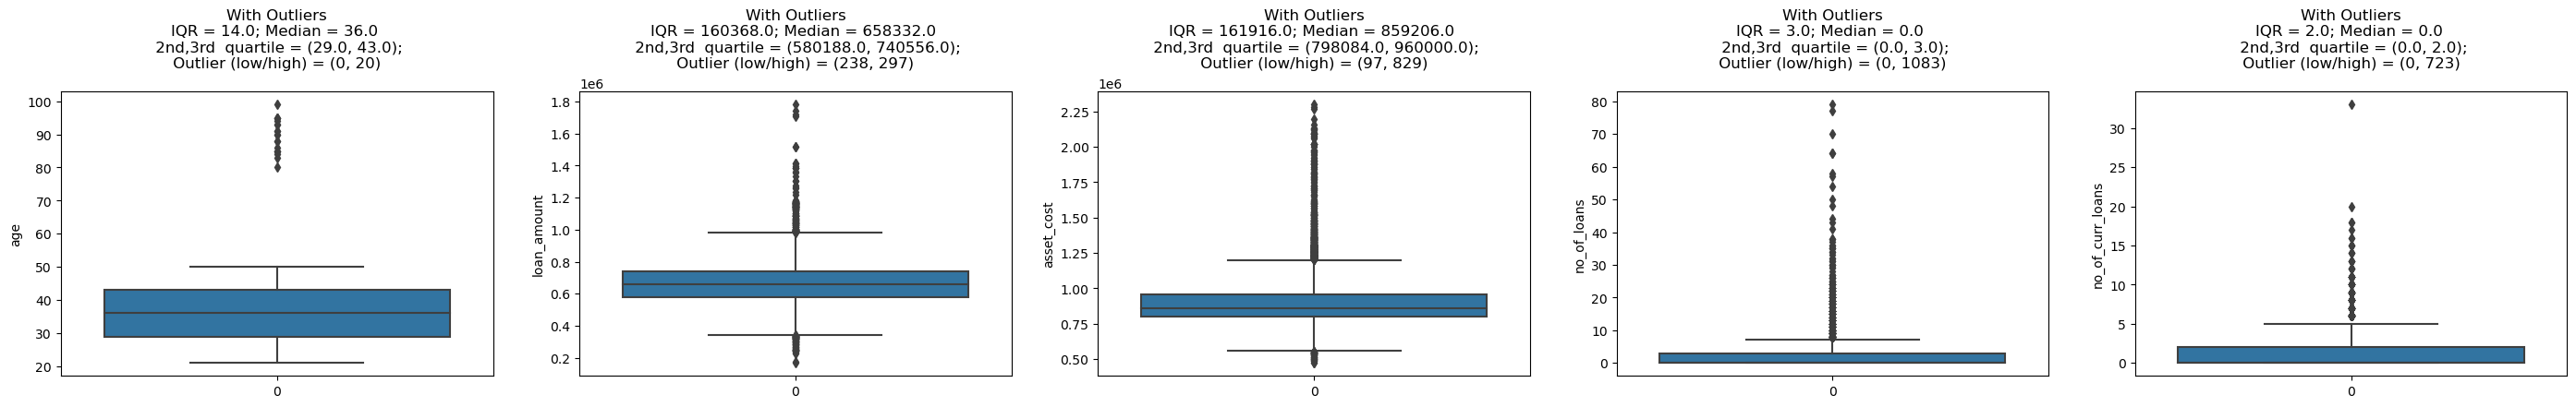

In [9]:
UVA_outlier(df, cat1,)

/tmp/ipykernel_20/417546151.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]>whis_high] = whis_high+1
/tmp/ipykernel_20/417546151.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]<whis_low] = whis_low-1
/tmp/ipykernel_20/417546151.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]>whis_high] = whis_high+1
/tmp/ipykernel_20/417546151.py:48: SettingWithCopyWarning: 
A value is trying to be set

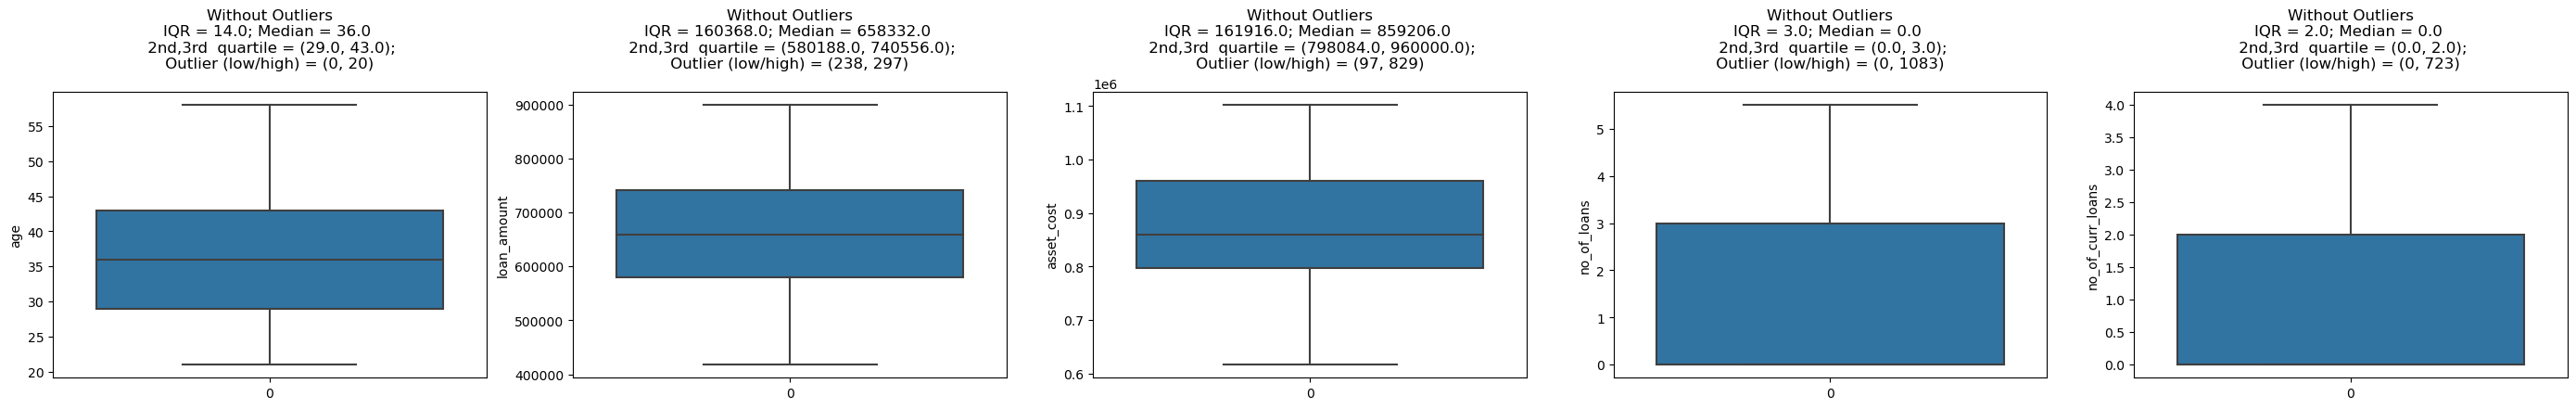

In [10]:
df2 = UVA_outlier(df, cat1,include_outlier=False)

In [11]:
df['education'].fillna(0, inplace=True)

In [12]:
df2.isnull().sum()

age                  0
education            0
loan_amount          0
asset_cost           0
no_of_loans          0
no_of_curr_loans     0
last_delinq_none     0
loan_default         0
proof_submitted_0    0
proof_submitted_1    0
proof_submitted_2    0
proof_submitted_3    0
proof_submitted_4    0
proof_submitted_5    0
proof_submitted_6    0
dtype: int64

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Assuming you have x_train, y_train, x_test, and y_test as your data
target = 'loan_default'
X = df2.loc[:, df2.columns!=target]
Y = df2.loc[:, df2.columns==target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Implementing the model

In [14]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the scaler on the specified columns of the training data
columns_to_scale = ['loan_amount', 'asset_cost']
x_train_scaled = X_train.copy()  # Make a copy of x_train to keep original data unchanged
x_train_scaled[columns_to_scale] = scaler.fit_transform(x_train_scaled[columns_to_scale])

# Transform the specified columns of the test data using the same scaler
x_test_scaled = X_test.copy()  # Make a copy of x_test to keep original data unchanged
x_test_scaled[columns_to_scale] = scaler.transform(x_test_scaled[columns_to_scale])

# Now you can use x_train_scaled and x_test_scaled for training and testing


In [15]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier
svm_classifier = SVC(kernel='poly', random_state=42)
svm_classifier.fit(X_train, Y_train)

# Calculate and print SVM accuracy
svm_accuracy = accuracy_score(Y_test, svm_classifier.predict(X_test))
print(f"SVM Accuracy: {svm_accuracy:.2f}")


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Accuracy: 0.58


# Visual Representation of the model's prediction

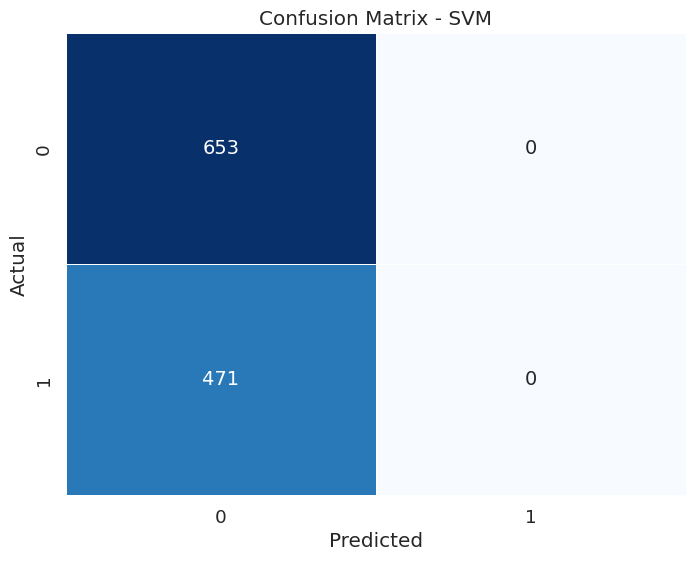

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained the SVM classifier and calculated the SVM accuracy
svm_predictions = svm_classifier.predict(X_test)
conf_matrix_svm = confusion_matrix(Y_test, svm_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 14}, linewidths=0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


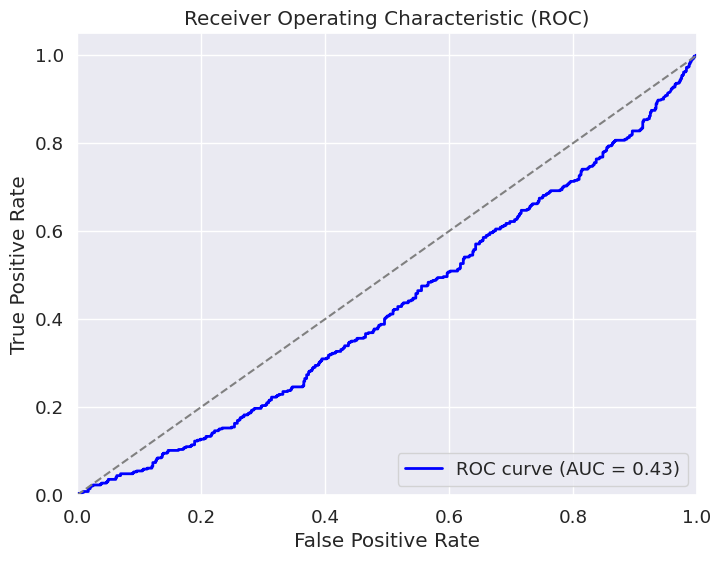

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize the SVM classifier with probability=True
svm_classifier = SVC(kernel='poly', probability=True, random_state=42)
svm_classifier.fit(X_train, Y_train)

# Get predicted probabilities for the positive class
svm_probs = svm_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, svm_probs)
roc_auc = roc_auc_score(Y_test, svm_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Implementing my trained model on my TEST DATA

In [18]:
df3 = pd.read_csv("/kaggle/input/ai-club-induction-2023-24/test_data.csv")
df3.head()

,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none
0,6501,27,1.0,Aadhar,740556,852000,5,0,0
1,2945,44,2.0,Aadhar,658236,816432,3,0,0
2,2025,35,1.0,Aadhar,548220,768732,0,0,0
3,264,43,2.0,Aadhar,460668,798360,0,0,0
4,4351,40,2.0,Aadhar,696156,792000,2,2,0


In [19]:
# Numerical datatypes
df3.select_dtypes(include=['int64','float64','Int64']).dtypes
cat1=['age','loan_amount','asset_cost','no_of_loans','no_of_curr_loans']

In [20]:
# custom function for easy outlier analysis

def UVA_outlier(df3, var_group, include_outlier = True):
  '''
  Univariate_Analysis_outlier:
  takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

  data : dataframe from which to plot from\n
  var_group : {list} type Group of Continuous variables\n
  include_outlier : {bool} whether to include outliers or not, default = True\n
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 100)
  # df2 = df[var_group][:]
  #looping for each variable
  for j,i in enumerate(var_group):

    # calculating descriptives of variable
    quant25 = df3[i].quantile(0.25)
    quant75 = df3[i].quantile(0.75)
    IQR = quant75 - quant25
    med = df3[i].median()
    whis_low = med-(1.5*IQR)
    whis_high = med+(1.5*IQR)

    # Calculating Number of Outliers
    outlier_high = len(df3[i][df3[i]>whis_high])
    outlier_low = len(df3[i][df3[i]<whis_low])

    if include_outlier == True:
      print(include_outlier)
      #Plotting the variable with every information
      plt.subplot(1,size,j+1)
      sns.boxplot(df3[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

    else:
      # replacing outliers with max/min whisker
      df3[i][df3[i]>whis_high] = whis_high+1
      df3[i][df3[i]<whis_low] = whis_low-1

      # plotting without outliers
      plt.subplot(1,size,j+1)
      sns.boxplot(df3[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
  return df3

True
True
True
True
True


,loan_id,age,education,proof_submitted,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none
0,6501,27,1.0,Aadhar,740556,852000,5,0,0
1,2945,44,2.0,Aadhar,658236,816432,3,0,0
2,2025,35,1.0,Aadhar,548220,768732,0,0,0
3,264,43,2.0,Aadhar,460668,798360,0,0,0
4,4351,40,2.0,Aadhar,696156,792000,2,2,0
...,...,...,...,...,...,...,...,...,...
1395,3485,32,1.0,Aadhar,639636,879276,0,0,0
1396,1861,27,1.0,Aadhar,589740,875316,5,2,0
1397,4975,34,2.0,Aadhar,619836,964812,0,0,0
1398,388,28,2.0,Aadhar,801228,1321200,0,0,0


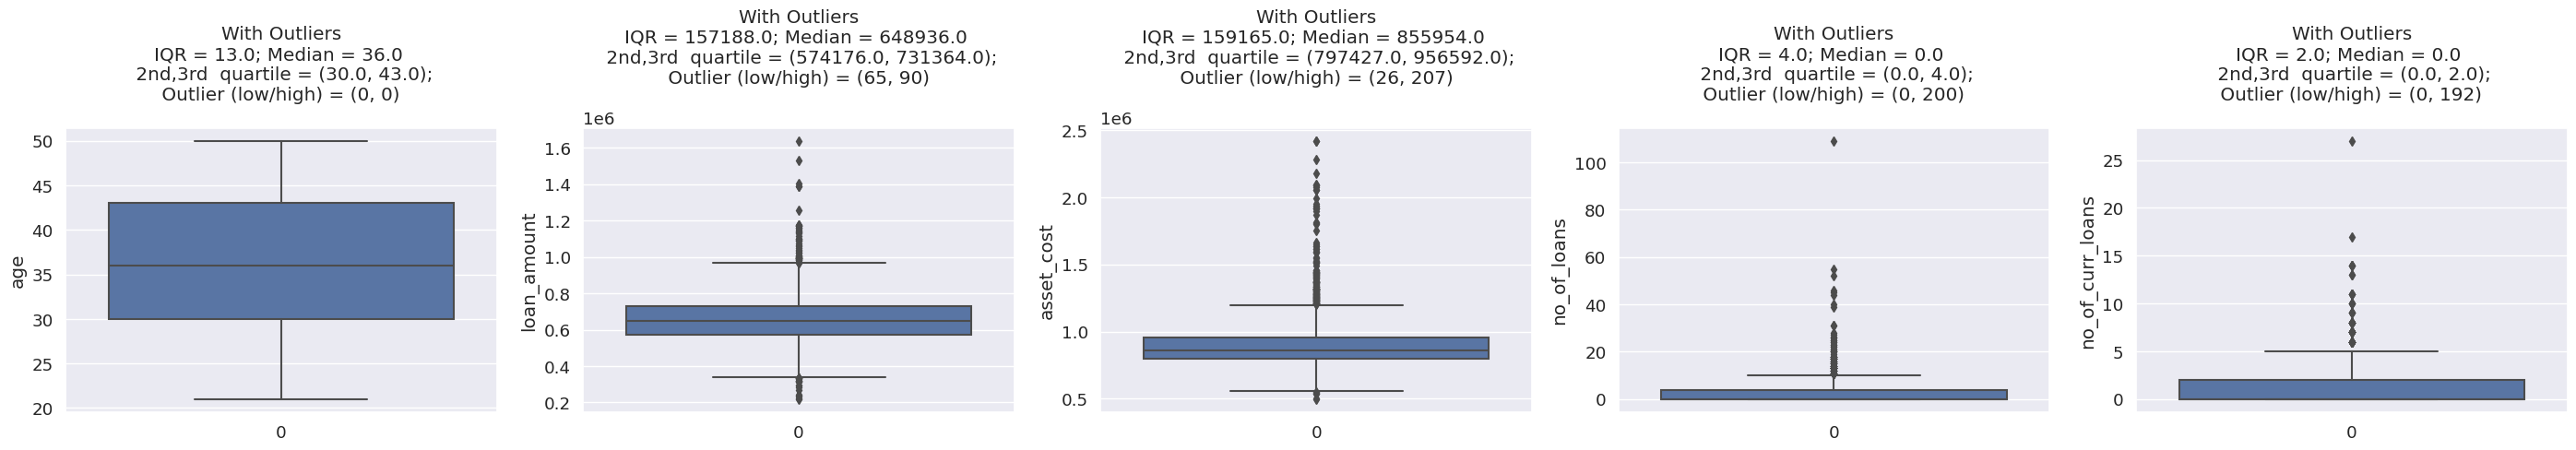

In [21]:
UVA_outlier(df3, cat1,)

/tmp/ipykernel_20/1528540717.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[i][df3[i]>whis_high] = whis_high+1
/tmp/ipykernel_20/1528540717.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[i][df3[i]<whis_low] = whis_low-1
/tmp/ipykernel_20/1528540717.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[i][df3[i]>whis_high] = whis_high+1
/tmp/ipykernel_20/1528540717.py:48: SettingWithCopyWarning: 
A value is trying

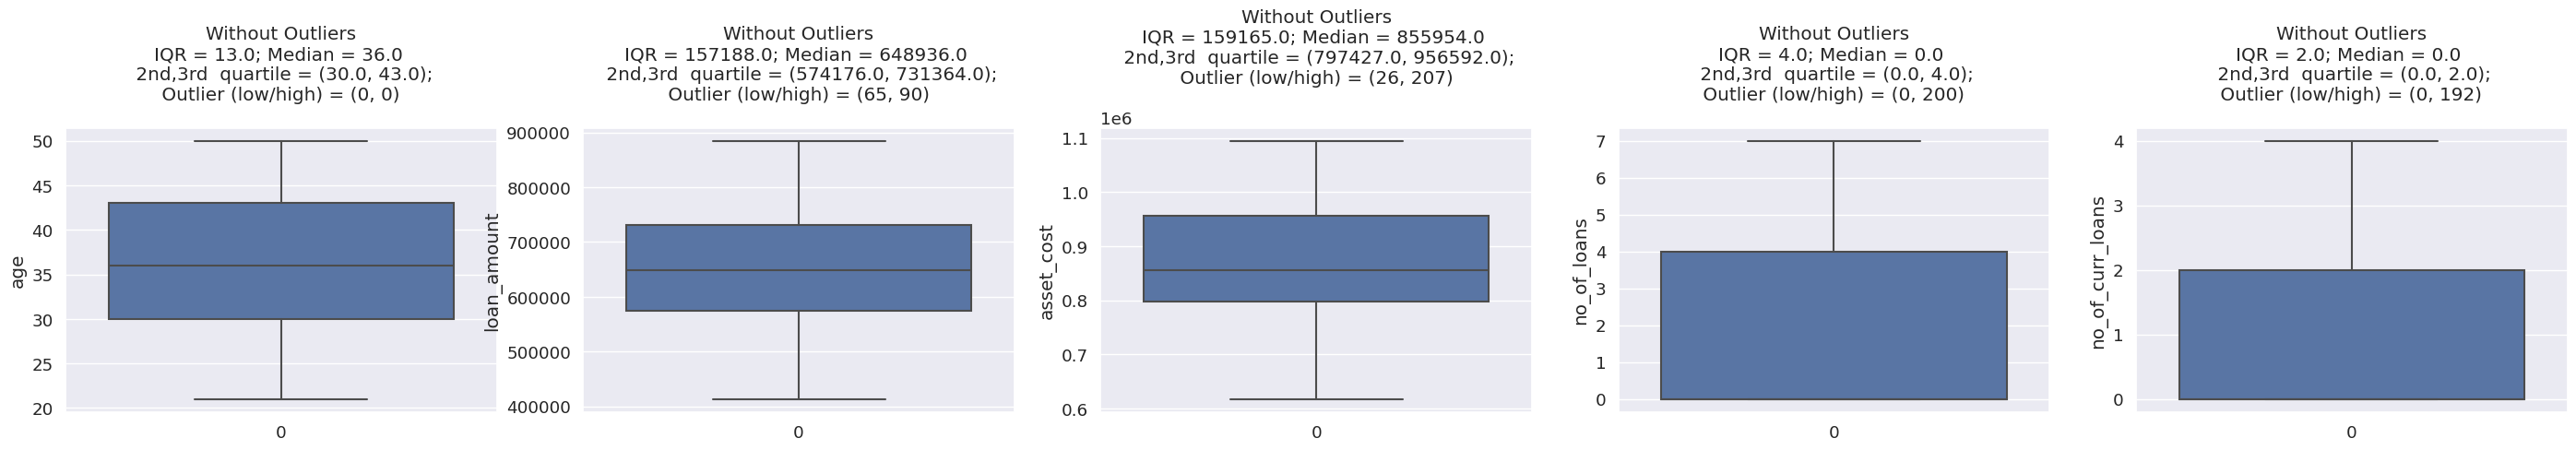

In [22]:
df4 = UVA_outlier(df3, cat1,include_outlier=False)

In [23]:
df4.isnull().sum()

loan_id              0
age                  0
education           56
proof_submitted      0
loan_amount          0
asset_cost           0
no_of_loans          0
no_of_curr_loans     0
last_delinq_none     0
dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split
one_hot_encoder = OneHotEncoder(sparse=False)
proof_submitted_encoded = df4[['proof_submitted']]
proof_submitted_one_hot = one_hot_encoder.fit_transform(proof_submitted_encoded)
proof_submitted_one_hot_df4 = pd.DataFrame(proof_submitted_one_hot, columns=[f'proof_submitted_{i}' for i in range(proof_submitted_one_hot.shape[1])])

df4 = pd.concat([df4, proof_submitted_one_hot_df4], axis=1)
df4.drop(['proof_submitted',], axis=1, inplace=True)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
import pandas as pd

columns_to_remove = ['loan_id']
df4 = df4.drop(columns=columns_to_remove)
df4.head()

,age,education,loan_amount,asset_cost,no_of_loans,no_of_curr_loans,last_delinq_none,proof_submitted_0,proof_submitted_1,proof_submitted_2,proof_submitted_3,proof_submitted_4
0,27,1.0,740556,852000.0,5,0,0,1.0,0.0,0.0,0.0,0.0
1,44,2.0,658236,816432.0,3,0,0,1.0,0.0,0.0,0.0,0.0
2,35,1.0,548220,768732.0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,43,2.0,460668,798360.0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,40,2.0,696156,792000.0,2,2,0,1.0,0.0,0.0,0.0,0.0


In [26]:
df4.isnull().sum()

age                   0
education            56
loan_amount           0
asset_cost            0
no_of_loans           0
no_of_curr_loans      0
last_delinq_none      0
proof_submitted_0     0
proof_submitted_1     0
proof_submitted_2     0
proof_submitted_3     0
proof_submitted_4     0
dtype: int64

In [27]:
df4['education'].fillna(0, inplace=True)

In [28]:
df4['proof_submitted_5'] = 0
df4['proof_submitted_6'] = 0


In [29]:
predictions = svm_classifier.predict(df4)

In [30]:
original_test = pd.read_csv("/kaggle/input/ai-club-induction-2023-24/test_data.csv")

In [31]:
# Create a new DataFrame
new_data = {'loan_id': original_test['loan_id'], 'loan_default': predictions}
new_df = pd.DataFrame(new_data)

new_df.head()

,loan_id,loan_default
0,6501,0
1,2945,0
2,2025,0
3,264,0
4,4351,0


In [32]:
new_df = pd.DataFrame(new_data)

# Save the DataFrame to a CSV file
csv_filename = 'predictions.csv'
new_df.to_csv(csv_filename, index=False)

# To download the CSV file in a Kaggle Notebook
from IPython.display import FileLink
FileLink(csv_filename)

/kaggle/working/predictions.csv

#  Feature Engineering for Future 

/tmp/ipykernel_20/412607004.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, Y_train)


age: 0.2266
education: 0.0297
loan_amount: 0.3431
asset_cost: 0.2975
no_of_loans: 0.0425
no_of_curr_loans: 0.0324
last_delinq_none: 0.0039
proof_submitted_0: 0.0082
proof_submitted_1: 0.0036
proof_submitted_2: 0.0001
proof_submitted_3: 0.0043
proof_submitted_4: 0.0010
proof_submitted_5: 0.0009
proof_submitted_6: 0.0062


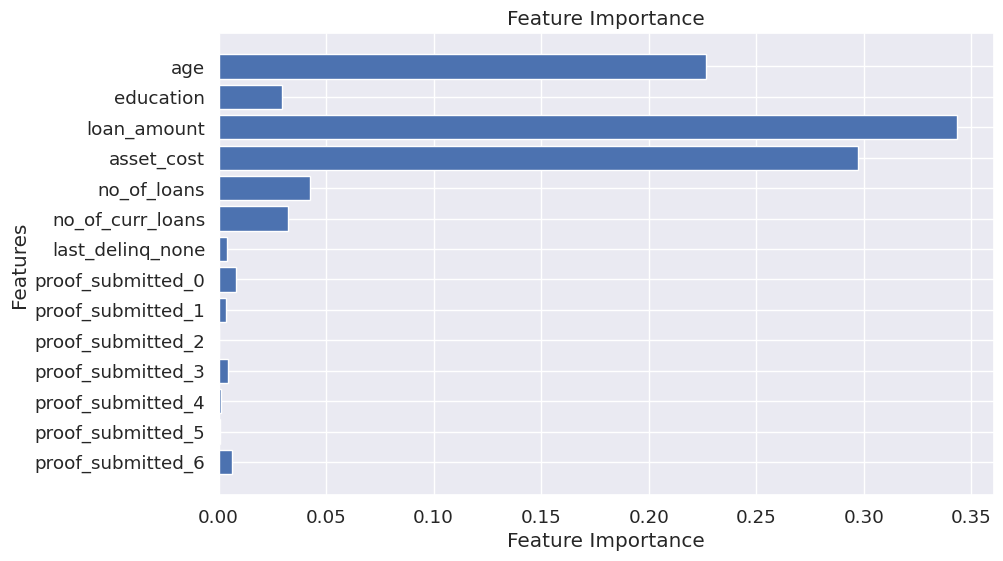

In [33]:
import matplotlib.pyplot as plt

# Assuming you have already trained the SVM classifier (or any other classifier)
# For SVM, you might want to use other methods to understand feature importance
# For illustrative purposes, let's assume you're using a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, Y_train)

# Get feature importances
feature_importances = classifier.feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

# Create a bar graph of feature importances
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()
